In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import torch
import torchvision.transforms as transforms 
from PIL import Image
from sklearn.metrics.ranking import roc_auc_score
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import math
import sys
import zipfile
import os
import cv2
import numpy as np
sys.path.append('/content/gdrive/My Drive/CSE6250BDH-PROJECT')
from config import DenseNet121, ResNet152, GoogleNet, ResNet18

In [0]:
nnClassCount = 5
imgtransCrop = 224

# Class names
class_names_14 = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 
               'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
               'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
class_names_5 = ['Cardiomegaly', 'Edema', 'Consolidation', 'Atelectasis', 'Pleural Effusion']

if nnClassCount == 14:
    class_names = class_names_14
else:
    class_names = class_names_5

use_gpu = torch.cuda.is_available()

In [4]:
# Path to CheXpert-v1.0-small.zip file on Google Drive
fpath = '/content/gdrive/My Drive/CheXpert-v1.0-small.zip'
os.path.exists(fpath)

True

In [5]:
%%time
# Extract images to current directory.
# This should take no more than 4 to 5 mins,
if not os.path.exists("CheXpert-v1.0-small/"):
  root = ""
  with zipfile.ZipFile(fpath, 'r') as z:
                  z.extractall(root)

CPU times: user 2min 8s, sys: 51 s, total: 2min 59s
Wall time: 4min 26s


In [0]:
class HeatmapGenerator ():
    
    #---- Initialize heatmap generator
    #---- pathModel - path to the trained densenet model
    #---- nnArchitecture - architecture name DENSE-NET121, DENSE-NET169, DENSE-NET201
    #---- nnClassCount - class count, 14 for chxray-14

 
    def __init__ (self, network: str, pathModel, nnClassCount, transCrop):

        # Check if the network is one of the 4 allowed:
        assert network.lower() in ['densenet121'], "Only DenseNet121 is implemented"
        self.network = network.lower()

        #---- Initialize the network
        model = DenseNet121(nnClassCount,).cuda()
        
        modelCheckpoint = torch.load(pathModel)
        model.load_state_dict(modelCheckpoint['model_state_dict'])

        # Optional if we multiple GPU
        if use_gpu:
            model = torch.nn.DataParallel(model).cuda()
        else:
            model = torch.nn.DataParallel(model)

        self.model = model
        self.model.eval()
        
        #---- Initialize the weights
        self.weights = list(self.model.module.densenet121.features.parameters())[-2]

        #---- Initialize the image transform
        self.transformSequence = transforms.Compose([
            transforms.Resize(transCrop),
            transforms.RandomCrop(transCrop),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        # normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        # transformList = []
        # transformList.append(transforms.Resize((transCrop, transCrop)))
        # transformList.append(transforms.ToTensor())
        # transformList.append(normalize)  
        # self.transformSequence = transforms.Compose(transformList)
    
    #--------------------------------------------------------------------------------
     
    def generate (self, pathImageFile, pathOutputFile, transCrop):
        
        #---- Load image, transform, convert 
        with torch.no_grad():
 
            imageData = Image.open(pathImageFile).convert('RGB')
            imageData = self.transformSequence(imageData)
            imageData = imageData.unsqueeze_(0)
            if use_gpu:
                imageData = imageData.cuda()
            l = self.model(imageData)
            probs = torch.sigmoid(l)
            output = self.model.module.densenet121.features(imageData)
            label = class_names[torch.max(probs,1)[1]]
            #---- Generate heatmap
            heatmap = None
            for i in range (0, len(self.weights)):
                map = output[0,i,:,:]
                if i == 0: heatmap = self.weights[i] * map
                else: heatmap += self.weights[i] * map
                npHeatmap = heatmap.cpu().data.numpy()

        #---- Blend original and heatmap 
                
        imgOriginal = cv2.imread(pathImageFile, 1)
        imgOriginal = cv2.resize(imgOriginal, (transCrop, transCrop))
        
        cam = npHeatmap / np.max(npHeatmap)
        cam = cv2.resize(cam, (transCrop, transCrop))
        heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
        
        img = cv2.addWeighted(imgOriginal,1,heatmap,0.35,0)            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.title(label)
        plt.imshow(img)
        plt.plot()
        plt.axis('off')
        plt.savefig(pathOutputFile)
        plt.show()
        return probs.cpu()

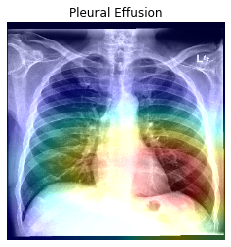

In [29]:
pathInputImage = '/content/CheXpert-v1.0-small/valid/patient64542/study1/view1_frontal.jpg'
pathOutputImage = 'heatmap_view1_frontal.png'
pathModel = '/content/gdrive/My Drive/CSE6250BDH-PROJECT/models/DenseNet121_2019.11.16.131915'
modelCheckpoint = torch.load(pathModel)
network = 'DenseNet121'

h = HeatmapGenerator(network, pathModel, nnClassCount, imgtransCrop)

probs = h.generate(pathInputImage, pathOutputImage, imgtransCrop)

In [8]:
probs

tensor([[0.0024, 0.0017, 0.0027, 0.0024, 0.0054]])

In [9]:
# Optional if we multiple GPU
if use_gpu:
    model = torch.nn.DataParallel(model).cuda()
else:
    model = torch.nn.DataParallel(model)

NameError: ignored